In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import datetime as dt
# import yfinance as yf

import math
import pandas_ta as pta
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [4]:
def getOldData(source_path):
    df = pd.read_csv(source_path, sep = ',')
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    print(df.head())
    print(df.shape[0])
    return df

source_path = 'D:/Rutgers/Spring 2022 (Sophomore)/Deep Learning/Final Project/AAPL_1min.txt'
APPL_df = getOldData(source_path)

                  Time    Open    High     Low   Close  Volume
0  2010-01-04 04:37:00  6.5064  6.5064  6.5064  6.5064    2800
1  2010-01-04 04:46:00  6.5064  6.5064  6.5064  6.5064    2800
2  2010-01-04 05:06:00  6.5119  6.5119  6.5119  6.5119    2800
3  2010-01-04 05:12:00  6.5123  6.5123  6.5123  6.5123    2800
4  2010-01-04 05:16:00  6.5162  6.5162  6.5162  6.5162    2800
1607283


In [5]:
ema_12 = APPL_df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = APPL_df['Close'].ewm(span=26, adjust=False).mean()
APPL_df['MACD'] = ema_12 - ema_26
APPL_df['RSI14'] = pta.rsi(APPL_df['Close'], length=14)

In [55]:
APPL_df['Datetime'] = index=pd.to_datetime(APPL_df['Time'], format = "%Y-%m-%d %H:%M:%S")
APPL_df = APPL_df.set_index(pd.DatetimeIndex(APPL_df['Datetime']))
APPL_df = APPL_df.drop('Datetime', axis=1)

df_10min = APPL_df.resample('10Min').mean().backfill()

print(df_10min)

                          Open       High       Low     Close  Volume  \
Datetime                                                                
2010-01-04 04:30:00   6.506400   6.506400   6.50640   6.50640  2800.0   
2010-01-04 04:40:00   6.506400   6.506400   6.50640   6.50640  2800.0   
2010-01-04 04:50:00   6.511900   6.511900   6.51190   6.51190  2800.0   
2010-01-04 05:00:00   6.511900   6.511900   6.51190   6.51190  2800.0   
2010-01-04 05:10:00   6.514250   6.514250   6.51425   6.51425  2800.0   
...                        ...        ...       ...       ...     ...   
2019-12-31 19:10:00  72.369567  72.369567  72.36220  72.36220  3580.0   
2019-12-31 19:20:00  72.362200  72.362200  72.36220  72.36220   600.0   
2019-12-31 19:30:00  72.351700  72.351700  72.35110  72.35110  3559.0   
2019-12-31 19:40:00  72.352820  72.352820  72.34888  72.34888  3192.0   
2019-12-31 19:50:00  72.343960  72.345920  72.34248  72.34444  5452.8   

                         MACD      RSI14  
Datetim

In [62]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def RemoveAndFormatNAN(dataset):
  
  # Ignore When the Market Is Closed
  dataset['Hour'] = dataset.index.hour
  dataset = dataset[dataset['Hour'] > 3]
  dataset = dataset[dataset['Hour'] < 20]
  dataset = dataset.drop('Hour', axis=1)

  # Ignore Weekends
  dataset['Day'] = dataset.index.dayofweek
  dataset = dataset[dataset['Day'] < 5]
  dataset = dataset.drop('Day', axis=1)

  #Ignore Holidays
  cal = calendar()
  holidays = [x for x in cal.holidays(start='2010-01-01', end='2019-12-31')]
  dataset = dataset[~dataset.index.normalize().isin(holidays)]

  return dataset

df_10min = RemoveAndFormatNAN(df_10min)

In [63]:
print(df_10min.head())
print(df_10min.shape)

                        Open     High      Low    Close  Volume      MACD  \
Datetime                                                                    
2010-01-04 04:30:00  6.50640  6.50640  6.50640  6.50640  2800.0  0.000000   
2010-01-04 04:40:00  6.50640  6.50640  6.50640  6.50640  2800.0  0.000000   
2010-01-04 04:50:00  6.51190  6.51190  6.51190  6.51190  2800.0  0.000439   
2010-01-04 05:00:00  6.51190  6.51190  6.51190  6.51190  2800.0  0.000439   
2010-01-04 05:10:00  6.51425  6.51425  6.51425  6.51425  2800.0  0.001106   

                         RSI14  
Datetime                        
2010-01-04 04:30:00  58.937198  
2010-01-04 04:40:00  58.937198  
2010-01-04 04:50:00  58.937198  
2010-01-04 05:00:00  58.937198  
2010-01-04 05:10:00  58.937198  
(240765, 7)


In [7]:
def load_dataset(dataset, time_step, isPrice=False):
  dataset = dataset.values
  data = []

  for i in range(len(dataset) - time_step):
    data.append(dataset[i:i+time_step])
  
  data = np.array(data)

  x_train = data[:, :-1]

  y_train = None

  if isPrice:
    y_train = data[:, -1]

  return [x_train, y_train]

In [8]:
# If dataset is concatendated

def x_dataset(dataset, features, time_step, scaler=False):

  if (dataset.shape[0] != features):
    dataset = dataset.T

  dataset = dataset.to_numpy()

  x_train = np.empty((dataset.shape[0], dataset.shape[1]-time_step, time_step))
  
  for i in range(dataset.shape[0]):
    for j in range(dataset.shape[1] - time_step):
      x_train[i, j, :] = dataset[i, j:j+time_step]

  return x_train

def y_dataset(dataset, time_step, scaler=False):
  
  dataset = dataset.to_numpy()
  y_train = dataset[time_step:]

  return  y_train

In [9]:
time_step = 50
features = 3

X = x_dataset(df_10min[['Open', 'MACD', 'RSI14']], features, time_step)
Y = y_dataset(df_10min[['Close']], time_step)

print(X.shape)
print(Y.shape)

(3, 249355, 50)
(249355, 1)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

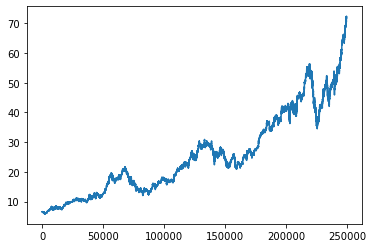

In [11]:
plt.plot(Y)

In [12]:
device = "cuda:0"

size = int(round(X.shape[1] * 0.8))


X_train = torch.tensor(X[:,:size,:], device=device)
X_test = torch.tensor(X[:,size:,:], device=device)

Y_train = torch.tensor(Y[:size], device=device)
Y_test = torch.tensor(Y[size:], device=device)

X_train = X_train.permute(1, 2, 0)
X_test = X_test.permute(1, 2, 0)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

torch.Size([199484, 50, 3])
torch.Size([49871, 50, 3])
torch.Size([199484, 1])
torch.Size([49871, 1])


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size, device=device).float()
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True, device=device)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size, device=device).float()
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # print(lstm_out.size())

        # reshape output from hidden cell into [batch, features] for `linear_2`
        # x = lstm_out.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x[:, -1, :])
        return predictions

model = LSTMModel(input_size=features, hidden_layer_size=32, num_layers=1, output_size=1, dropout=0.03)

In [16]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x,y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        out = model(x.float())

        # print("Out:", out.size())
        # print("y:", y.size())

        loss = criterion(out.squeeze(), y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr, out

# create `DataLoader`

# print(X_train.shape)
# print(Y_train.shape)

train = TensorDataset(X_train.float(), Y_train.squeeze().float())
test = TensorDataset(X_test.float(), Y_test.squeeze().float())
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

epochs=15
learning_rate = 1e-3

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

loss_list = []

# begin training
for epoch in range(epochs):
    loss_train, lr_train, out = run_epoch(train_dataloader, is_training=True)
    loss_list.append(loss_train)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f} | lr:{:.6f}'
              .format(epoch+1, epochs, loss_train, lr_train))

Epoch[1/15] | loss train:713.330769 | lr:0.001000
Epoch[2/15] | loss train:63.366367 | lr:0.001000
Epoch[3/15] | loss train:53.956874 | lr:0.001000
Epoch[4/15] | loss train:48.243075 | lr:0.001000
Epoch[5/15] | loss train:44.643200 | lr:0.001000
Epoch[6/15] | loss train:41.517101 | lr:0.001000
Epoch[7/15] | loss train:39.089251 | lr:0.001000
Epoch[8/15] | loss train:37.487022 | lr:0.001000
Epoch[9/15] | loss train:35.685432 | lr:0.001000
Epoch[10/15] | loss train:33.855945 | lr:0.001000
Epoch[11/15] | loss train:32.296858 | lr:0.001000
Epoch[12/15] | loss train:30.605415 | lr:0.001000
Epoch[13/15] | loss train:28.806384 | lr:0.001000
Epoch[14/15] | loss train:27.333335 | lr:0.001000
Epoch[15/15] | loss train:26.775965 | lr:0.001000


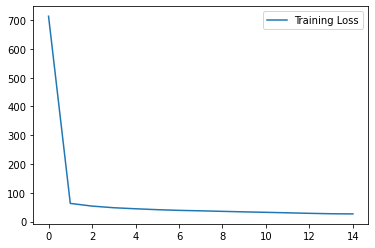

In [17]:
plt.plot(loss_list, label="Training Loss")
plt.legend()
plt.show()

(199484,)


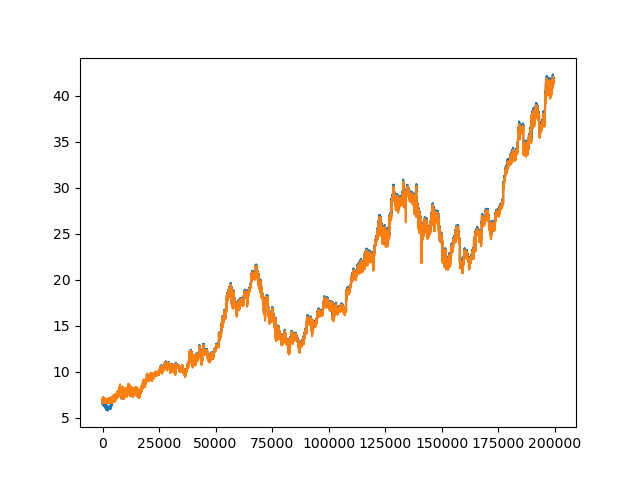

(49871,)
(49871,)


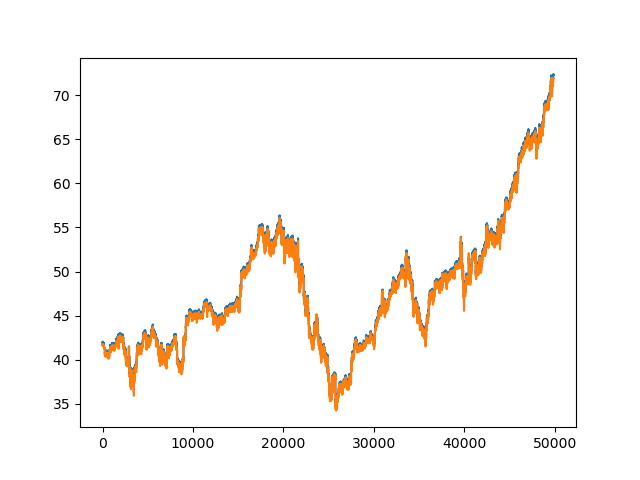

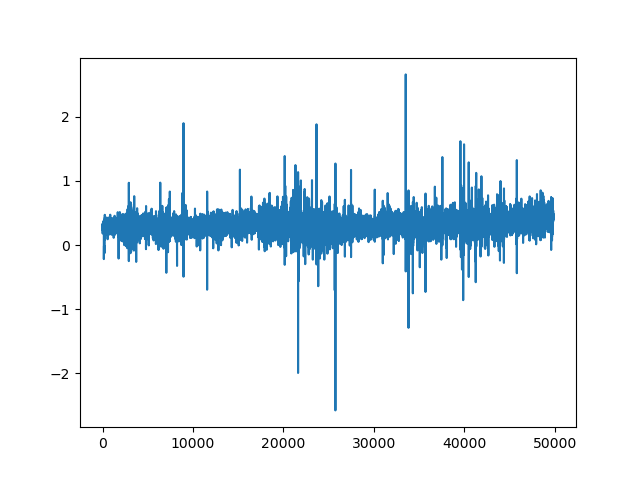

In [21]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])
predicted_true = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    out = model(x)
    out = torch.flatten(out).cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))
    predicted_true = np.concatenate((predicted_true, torch.flatten(y).cpu().numpy()))

# predict on the validation data, to see how the model does

print(predicted_train.shape)

# predicted_train = scaler.inverse_transform(predicted_train.reshape(-1,1))
# predicted_true = scaler.inverse_transform(predicted_true.reshape(-1,1))

test_dataloader = DataLoader(test, batch_size=64, shuffle=False)

predicted_test = np.array([])
predicted_true_test = np.array([])

losslist = []

for idx, (x, y) in enumerate(test_dataloader):
    out = model(x)
    losslist.append(criterion(out.squeeze(), y))
    out = torch.flatten(out).cpu().detach().numpy()
    predicted_test = np.concatenate((predicted_test, out))
    predicted_true_test = np.concatenate((predicted_true_test, torch.flatten(y).cpu().numpy()))

# predicted_test = scaler.inverse_transform(predicted_test.reshape(-1,1))
# predicted_true_test = scaler.inverse_transform(predicted_true_test.reshape(-1,1))

import matplotlib.pyplot as plt

# prepare data for plotting, show predicted prices

f1, ax1 = plt.subplots(1)

ax1.plot(predicted_true)
ax1.plot(predicted_train)
# title('Training Dataset - APPL Price 2010-mid2018')
# ax1.set_ylim(ymin=0)
plt.show(f1)

f2, ax2 = plt.subplots(1)

print(predicted_true_test.shape)
print(predicted_test.shape)

ax2.plot(predicted_true_test)
ax2.plot(predicted_test)

# title('Test Dataset - APPL Price mid2018 - 2019')
# ax2.set_ylim(ymin=0)
plt.show(f2)

f3, ax3 = plt.subplots(1)

ax3.plot(predicted_true_test - predicted_test)
# title('Test Dataset - APPL Price mid2018 - 2019')
# ax3.set_ylim(ymin=0)
plt.show(f3)

# fig = plt.figure()
# plt.plot(predicted_true_test)
# plt.plot(predicted_test)